# Full ARIMA Model Testing

For today, we will summarize all the different things we learned so far. We will fetch a time series from FRED, optionally compute its percentage change (for inflation or growth rates), and perform stationarity tests (ADF, KPSS, PP) to determine if differencing is needed. It then selects the optimal ARMA(p, q) model based on AIC, fits the model, and analyzes residuals using time series plots, histograms, and QQ plots. To ensure the model is valid, it conducts Ljung-Box tests (autocorrelation) and Shapiro-Wilk tests (normality), printing a clear conclusion on whether the residuals are white noise. The function outputs an information criteria table, optimal ARMA order, and diagnostic results, helping users assess and model time series data effectively. 

## Importing the Dataset

              CPI  YoY_Inflation
Date                            
2000-01-01  169.3            NaN
2000-02-01  170.0            NaN
2000-03-01  171.0            NaN
2000-04-01  170.9            NaN
2000-05-01  171.2            NaN


<Axes: title={'center': 'US Monthly Inflation Rate (YoY)'}, xlabel='Date'>

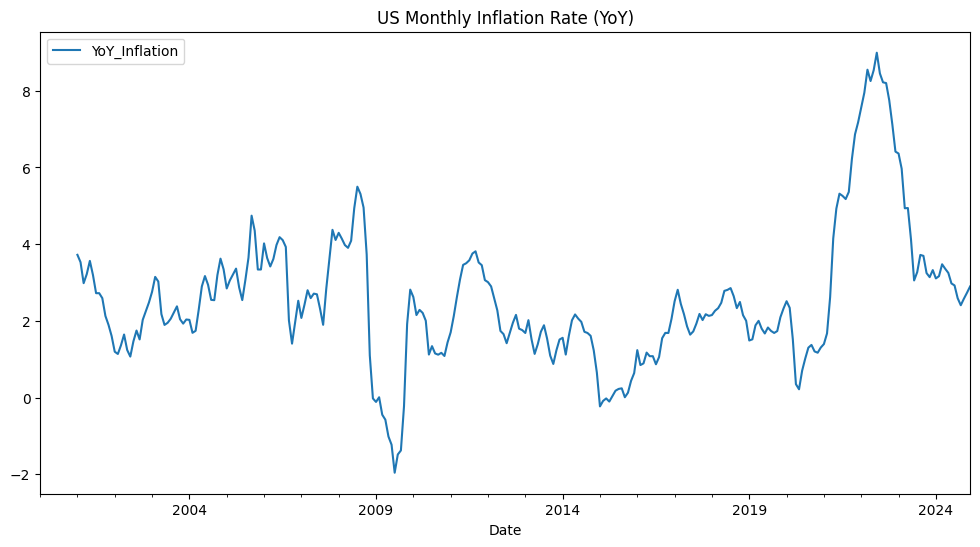

In [1]:
from fredapi import Fred
import pandas as pd

# Replace 'your_api_key' with your actual FRED API key
fred = Fred(api_key='fe3741e38a5245c3cc826f2d6ae3e1f2')

# Fetch US Monthly Inflation data (CPI)
cpi_data = fred.get_series('CPIAUCSL', observation_start='2000-01-01')

# Convert to DataFrame
cpi_df = pd.DataFrame(cpi_data, columns=['CPI'])
cpi_df.index.name = 'Date'

# Compute Year-on-Year Inflation Rate
cpi_df['YoY_Inflation'] = cpi_df['CPI'].pct_change(periods=12) * 100  # Percentage change over 12 months

# Display the first few rows
print(cpi_df.head())

# GRaph the YoY Inflation Rate
cpi_df['YoY_Inflation'].plot(title='US Monthly Inflation Rate (YoY)', legend=True, figsize=(12, 6))


## ACF and PACF

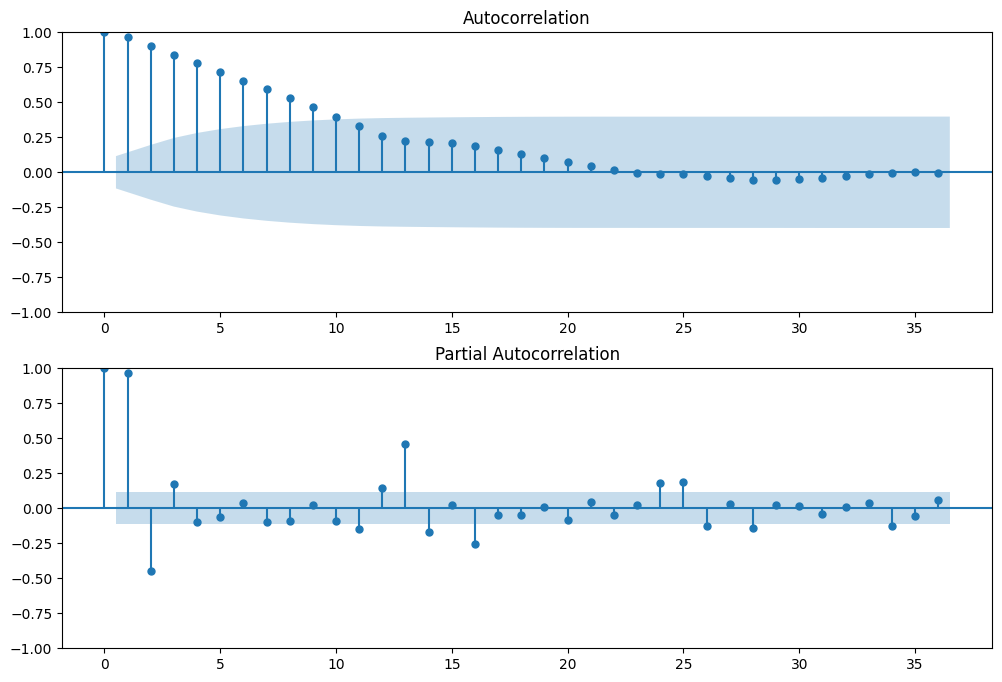

In [7]:
# Generate the PACF and ACF plots for the YoY Inflation Rate
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(cpi_df['YoY_Inflation'].dropna(), lags=36, ax=ax[0])
plot_pacf(cpi_df['YoY_Inflation'].dropna(), lags=36, ax=ax[1])
plt.show()

## Unit Root Testing

In [6]:
from statsmodels.tsa.stattools import adfuller, kpss
from arch.unitroot import PhillipsPerron
import pandas as pd

# Function to print test results
def print_test_results(test_name, test_stat, p_value, critical_values):
    print(f"\n{test_name} Test Results:")
    print(f"Test Statistic: {test_stat}")
    print(f"P-Value: {p_value}")
    print("Critical Values:")
    for key, value in critical_values.items():
        print(f"   {key}: {value}")
    return p_value  # Return p-value for conclusion analysis

# Ensure there are no NaN values before performing the tests
cpi_df = cpi_df.dropna()

# Augmented Dickey-Fuller (ADF) Test
adf_result = adfuller(cpi_df['YoY_Inflation'], autolag='AIC')
adf_p_value = print_test_results("Augmented Dickey-Fuller", adf_result[0], adf_result[1], adf_result[4])

# KPSS Test
kpss_result = kpss(cpi_df['YoY_Inflation'], regression='c', nlags="auto")
kpss_p_value = print_test_results("KPSS", kpss_result[0], kpss_result[1], kpss_result[3])

# Phillips-Perron (PP) Test (Fixed Extraction)
pp_result = PhillipsPerron(cpi_df['YoY_Inflation'])  # This returns an object
pp_p_value = print_test_results("Phillips-Perron", pp_result.stat, pp_result.pvalue, pp_result.critical_values)

# Print the Conclusion
print("\n--- Conclusion ---")

# Checking Stationarity Based on Tests
stationary_adf = adf_p_value < 0.05
stationary_kpss = kpss_p_value > 0.05
stationary_pp = pp_p_value < 0.05

if stationary_adf and stationary_pp and stationary_kpss:
    print("The YoY Inflation Rate is likely STATIONARY based on all tests.")
elif stationary_adf and stationary_pp:
    print("The YoY Inflation Rate is STATIONARY based on ADF and PP tests, but KPSS suggests it may have a trend.")
elif stationary_kpss:
    print("The YoY Inflation Rate is NON-STATIONARY based on ADF and PP, but KPSS suggests it might be stationary with a trend.")
else:
    print("The YoY Inflation Rate is NON-STATIONARY based on all tests. Consider differencing the series.")


Augmented Dickey-Fuller Test Results:
Test Statistic: -2.9177691169452653
P-Value: 0.04332036680402734
Critical Values:
   1%: -3.4546223782586534
   5%: -2.8722253212300277
   10%: -2.5724638500216264

KPSS Test Results:
Test Statistic: 0.33041853841622965
P-Value: 0.1
Critical Values:
   10%: 0.347
   5%: 0.463
   2.5%: 0.574
   1%: 0.739

Phillips-Perron Test Results:
Test Statistic: -2.8648999950867413
P-Value: 0.04958454932200351
Critical Values:
   1%: -3.453342167806272
   5%: -2.871663828287282
   10%: -2.572164381381345

--- Conclusion ---
The YoY Inflation Rate is likely STATIONARY based on all tests.


/var/folders/ch/hh05jl8911q5dhp_1wptbrym0000gn/T/ipykernel_83987/1628838099.py:23: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(cpi_df['YoY_Inflation'], regression='c', nlags="auto")


## Lag Length Selection

In [8]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from IPython.display import display  # For Jupyter Notebook

# Define range for AR (p) and MA (q) lags to test
p_range = range(0, 6)  # Test AR lags from 0 to 5
q_range = range(0, 6)  # Test MA lags from 0 to 5

# Ensure no NaNs before fitting models
cpi_df = cpi_df.dropna()

# Define time series variable
y = cpi_df['YoY_Inflation']

# Store results in a DataFrame
ic_results = []

for p in p_range:
    for q in q_range:
        try:
            # Fit ARMA model (using ARIMA with no differencing, d=0)
            model = ARIMA(y, order=(p, 0, q)).fit()
            
            # Store results
            ic_results.append({
                'p': p,
                'q': q,
                'AIC': model.aic,
                'BIC': model.bic,
                'HQC': model.hqic
            })
        except Exception as e:
            # If a model fails to fit, log a high AIC/BIC to avoid selection
            ic_results.append({'p': p, 'q': q, 'AIC': np.inf, 'BIC': np.inf, 'HQC': np.inf})

# Convert to DataFrame
ic_df = pd.DataFrame(ic_results)

# Find the optimal lag based on AIC (lowest value)
optimal_row = ic_df.loc[ic_df['AIC'].idxmin()]

# Highlight optimal lags
ic_df['Optimal'] = (ic_df['p'] == optimal_row['p']) & (ic_df['q'] == optimal_row['q'])

# Display results (Use print or display for Jupyter)
display(ic_df)  # or print(ic_df) if running in a script

# Print optimal lag selection
print(f"\nOptimal ARMA(p, q) lags based on AIC: p = {optimal_row['p']}, q = {optimal_row['q']}")

/Users/justineloriaga/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/justineloriaga/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/justineloriaga/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/justineloriaga/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/justineloriaga/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/ba

,p,q,AIC,BIC,HQC,Optimal
0,0,0,1156.199260,1163.525180,1159.135047,False
1,0,1,792.433861,803.422743,796.837542,False
2,0,2,563.986649,578.638491,569.858223,False
3,0,3,425.283544,443.598346,432.623012,False
4,0,4,374.638638,396.616401,383.446000,False
5,0,5,348.044413,373.685136,358.319668,False
6,1,0,373.905046,384.893927,378.308726,False
7,1,1,299.914609,314.566451,305.786184,False
8,1,2,296.743773,315.058575,304.083241,False
9,1,3,297.658777,319.636540,306.466138,False



Optimal ARMA(p, q) lags based on AIC: p = 5.0, q = 3.0


## Residual Diagnostics

/Users/justineloriaga/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/justineloriaga/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/justineloriaga/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/justineloriaga/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/justineloriaga/Library/Python/3.

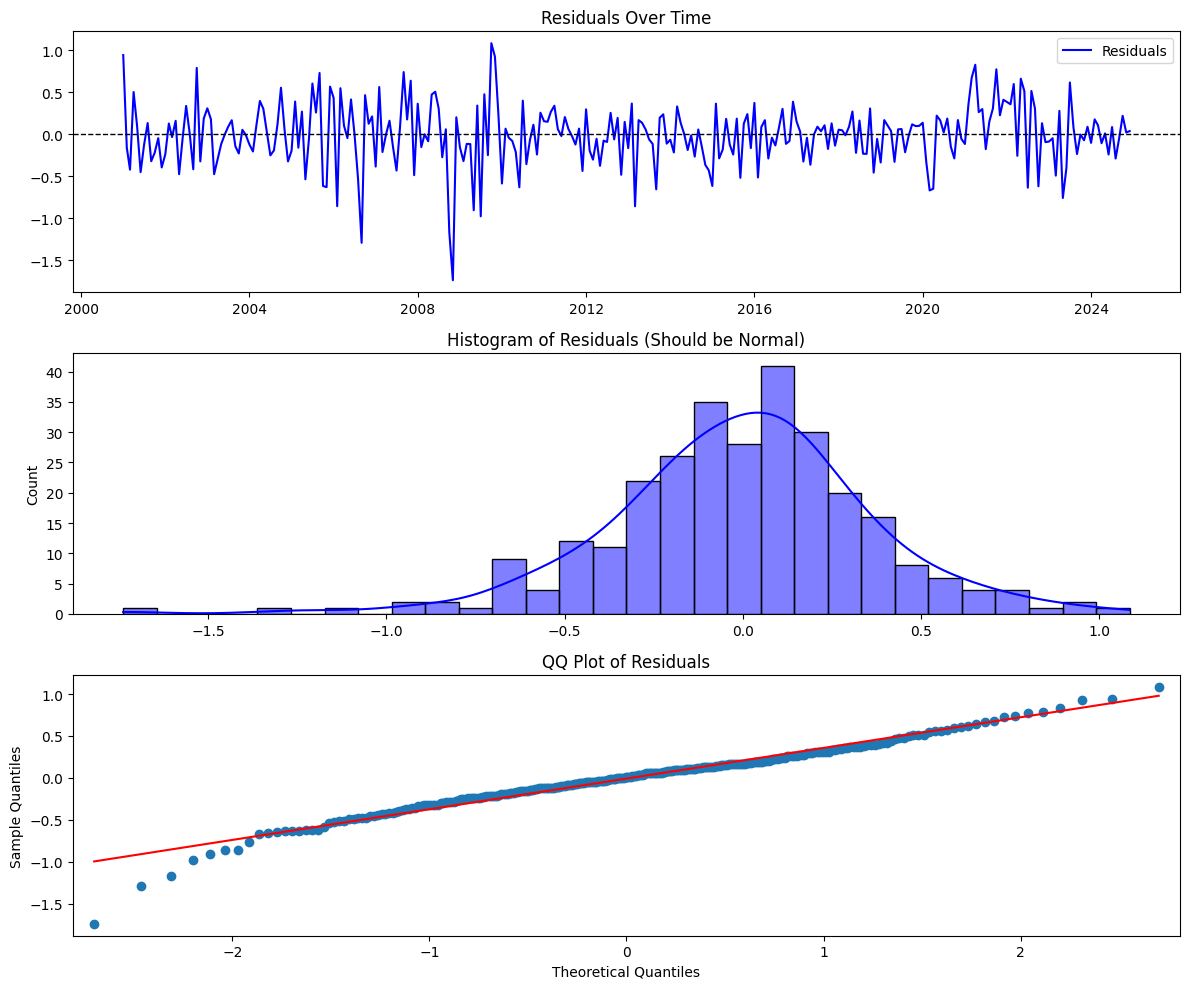


--- Residual Diagnostic Tests ---
Ljung-Box Test p-value: 0.8419 (p > 0.05 means residuals are white noise)
Shapiro-Wilk Normality Test p-value: 0.0001 (p > 0.05 means normality)
⚠️ Residuals have no autocorrelation but may not be normally distributed.


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import shapiro
import numpy as np

# Step 1: Fit the optimal ARMA model
p_opt = int(optimal_row['p'])  # Best AR lag
q_opt = int(optimal_row['q'])  # Best MA lag

# Fit ARMA(p, q) model using optimal lags
optimal_model = ARIMA(y, order=(p_opt, 0, q_opt)).fit()

# Get residuals
residuals = optimal_model.resid

# Step 2: Plot residuals
fig, ax = plt.subplots(3, 1, figsize=(12, 10))

# Time Series Plot of Residuals
ax[0].plot(residuals, label="Residuals", color="blue")
ax[0].axhline(y=0, linestyle="--", color="black", linewidth=1)
ax[0].set_title("Residuals Over Time")
ax[0].legend()

# Histogram of Residuals
sns.histplot(residuals, bins=30, kde=True, ax=ax[1], color="blue")
ax[1].set_title("Histogram of Residuals (Should be Normal)")

# QQ-Plot of Residuals
sm.qqplot(residuals, line="s", ax=ax[2])
ax[2].set_title("QQ Plot of Residuals")

plt.tight_layout()
plt.show()

# Step 3: Check if Residuals are White Noise

# Ljung-Box Test (Autocorrelation Check)
ljung_box_results = acorr_ljungbox(residuals, lags=[10], return_df=True)
lb_p_value = ljung_box_results['lb_pvalue'].values[0]

# Shapiro-Wilk Test (Normality Check)
shapiro_test = shapiro(residuals)
shapiro_p_value = shapiro_test.pvalue

# Print results
print("\n--- Residual Diagnostic Tests ---")
print(f"Ljung-Box Test p-value: {lb_p_value:.4f} (p > 0.05 means residuals are white noise)")
print(f"Shapiro-Wilk Normality Test p-value: {shapiro_p_value:.4f} (p > 0.05 means normality)")

# Conclusion
if lb_p_value > 0.05 and shapiro_p_value > 0.05:
    print("✅ Residuals appear to be white noise (no autocorrelation & normally distributed).")
elif lb_p_value > 0.05:
    print("⚠️ Residuals have no autocorrelation but may not be normally distributed.")
elif shapiro_p_value > 0.05:
    print("⚠️ Residuals are normally distributed but show signs of autocorrelation.")
else:
    print("❌ Residuals are NOT white noise. Consider adjusting the model.")

## One Big Happy Function

In [12]:
from fredapi import Fred
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller, kpss
from arch.unitroot import PhillipsPerron
from scipy.stats import shapiro
from IPython.display import display  # For better table visualization

def analyze_fred_series(api_key, series_id, start_date, pct_change=False):
    """
    Fetches a time series from FRED, tests for stationarity, selects an optimal ARMA model, 
    and performs residual diagnostics.

    Parameters:
    - api_key (str): Your FRED API key
    - series_id (str): The FRED series ID (e.g., 'CPIAUCSL' for CPI)
    - start_date (str): The start date for the data (YYYY-MM-DD)
    - pct_change (bool): Whether to compute the percentage change (for inflation rate, etc.)

    Returns:
    - Prints test results, optimal ARMA order, and residual diagnostics.
    """

    # Fetch Data
    fred = Fred(api_key=api_key)
    data = fred.get_series(series_id, observation_start=start_date)
    
    # Convert to DataFrame
    df = pd.DataFrame(data, columns=[series_id])
    df.index.name = 'Date'

    # Compute percentage change if needed
    if pct_change:
        df['YoY_Inflation'] = df[series_id].pct_change(periods=12) * 100
        y = df['YoY_Inflation']
    else:
        y = df[series_id]
    
    # Drop NaNs
    df = df.dropna()
    y = y.dropna()

    # --- STEP 1: Stationarity Tests ---
    def print_test_results(test_name, test_stat, p_value, critical_values):
        print(f"\n{test_name} Test Results:")
        print(f"Test Statistic: {test_stat:.4f}")
        print(f"P-Value: {p_value:.4f}")
        print("Critical Values:")
        for key, value in critical_values.items():
            print(f"   {key}: {value:.4f}")
        return p_value

    # ADF Test
    adf_p = print_test_results("Augmented Dickey-Fuller", *adfuller(y, autolag='AIC')[0:2], adfuller(y, autolag='AIC')[4])

    # KPSS Test
    kpss_p = print_test_results("KPSS", *kpss(y, regression='c', nlags="auto")[0:2], kpss(y, regression='c', nlags="auto")[3])

    # Phillips-Perron Test
    pp_result = PhillipsPerron(y)
    pp_p = print_test_results("Phillips-Perron", pp_result.stat, pp_result.pvalue, pp_result.critical_values)

    # Print Conclusion
    print("\n--- Stationarity Conclusion ---")
    if adf_p < 0.05 and pp_p < 0.05 and kpss_p > 0.05:
        print("✅ The series is likely STATIONARY.")
    elif adf_p < 0.05 and pp_p < 0.05:
        print("⚠️ The series is STATIONARY based on ADF & PP, but KPSS suggests a trend.")
    elif kpss_p > 0.05:
        print("⚠️ The series might be TREND STATIONARY.")
    else:
        print("❌ The series is NON-STATIONARY. Consider differencing the data.")

    # --- STEP 2: ARMA Model Selection ---
    print("\n--- Selecting Optimal ARMA Model ---")

    p_range = range(0, 6)  # AR Lags (p)
    q_range = range(0, 6)  # MA Lags (q)
    ic_results = []

    for p in p_range:
        for q in q_range:
            try:
                model = ARIMA(y, order=(p, 0, q)).fit()
                ic_results.append({'p': p, 'q': q, 'AIC': model.aic, 'BIC': model.bic, 'HQC': model.hqic})
            except:
                ic_results.append({'p': p, 'q': q, 'AIC': np.inf, 'BIC': np.inf, 'HQC': np.inf})

    ic_df = pd.DataFrame(ic_results)
    optimal_row = ic_df.loc[ic_df['AIC'].idxmin()]
    
    display(ic_df)  # Display table
    print(f"\n✅ Optimal ARMA Order: p = {optimal_row['p']}, q = {optimal_row['q']}")

    # --- STEP 3: Fit Final ARMA Model ---
    p_opt, q_opt = int(optimal_row['p']), int(optimal_row['q'])
    final_model = ARIMA(y, order=(p_opt, 0, q_opt)).fit()
    residuals = final_model.resid

    # --- STEP 4: Residual Diagnostics ---
    print("\n--- Residual Diagnostics ---")

    fig, ax = plt.subplots(3, 1, figsize=(12, 10))

    # Residual Time Series
    ax[0].plot(residuals, label="Residuals", color="blue")
    ax[0].axhline(y=0, linestyle="--", color="black", linewidth=1)
    ax[0].set_title("Residuals Over Time")
    ax[0].legend()

    # Histogram of Residuals
    sns.histplot(residuals, bins=30, kde=True, ax=ax[1], color="blue")
    ax[1].set_title("Histogram of Residuals (Should be Normal)")

    # QQ-Plot
    sm.qqplot(residuals, line="s", ax=ax[2])
    ax[2].set_title("QQ Plot of Residuals")

    plt.tight_layout()
    plt.show()

    # Ljung-Box Test (Autocorrelation)
    lb_p = acorr_ljungbox(residuals, lags=[10], return_df=True)['lb_pvalue'].values[0]

    # Shapiro-Wilk Test (Normality)
    shapiro_p = shapiro(residuals).pvalue

    # Print Test Results
    print(f"Ljung-Box Test p-value: {lb_p:.4f} (p > 0.05 means white noise)")
    print(f"Shapiro-Wilk Test p-value: {shapiro_p:.4f} (p > 0.05 means normality)")

    # Final Conclusion
    if lb_p > 0.05 and shapiro_p > 0.05:
        print("✅ Residuals are WHITE NOISE. The model is valid.")
    elif lb_p > 0.05:
        print("⚠️ No autocorrelation, but residuals may not be normal.")
    elif shapiro_p > 0.05:
        print("⚠️ Residuals are normal but show autocorrelation.")
    else:
        print("❌ Residuals are NOT white noise. Consider revising the model.")


Augmented Dickey-Fuller Test Results:
Test Statistic: -1.9200
P-Value: 0.3227
Critical Values:
   1%: -3.4526
   5%: -2.8713
   10%: -2.5720

KPSS Test Results:
Test Statistic: 1.4394
P-Value: 0.0100
Critical Values:
   10%: 0.3470
   5%: 0.4630
   2.5%: 0.5740
   1%: 0.7390

Phillips-Perron Test Results:
Test Statistic: -2.2337
P-Value: 0.1942
Critical Values:
   1%: -3.4524
   5%: -2.8713
   10%: -2.5719

--- Stationarity Conclusion ---
❌ The series is NON-STATIONARY. Consider differencing the data.

--- Selecting Optimal ARMA Model ---


/var/folders/ch/hh05jl8911q5dhp_1wptbrym0000gn/T/ipykernel_83987/4096523588.py:62: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_p = print_test_results("KPSS", *kpss(y, regression='c', nlags="auto")[0:2], kpss(y, regression='c', nlags="auto")[3])
/var/folders/ch/hh05jl8911q5dhp_1wptbrym0000gn/T/ipykernel_83987/4096523588.py:62: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_p = print_test_results("KPSS", *kpss(y, regression='c', nlags="auto")[0:2], kpss(y, regression='c', nlags="auto")[3])
/Users/justineloriaga/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/justineloriaga

,p,q,AIC,BIC,HQC
0,0,0,1820.197682,1827.605247,1823.162200
1,0,1,1476.990257,1488.101604,1481.437034
2,0,2,1257.133874,1271.949004,1263.062910
3,0,3,1147.775845,1166.294758,1155.187141
4,0,4,1068.625327,1090.848022,1077.518882
5,0,5,1034.182172,1060.108649,1044.557985
6,1,0,912.746187,923.857534,917.192964
7,1,1,894.684809,909.499939,900.613845
8,1,2,894.365755,912.884668,901.777051
9,1,3,895.448049,917.670744,904.341604



✅ Optimal ARMA Order: p = 3.0, q = 0.0

--- Residual Diagnostics ---


/Users/justineloriaga/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/justineloriaga/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/justineloriaga/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


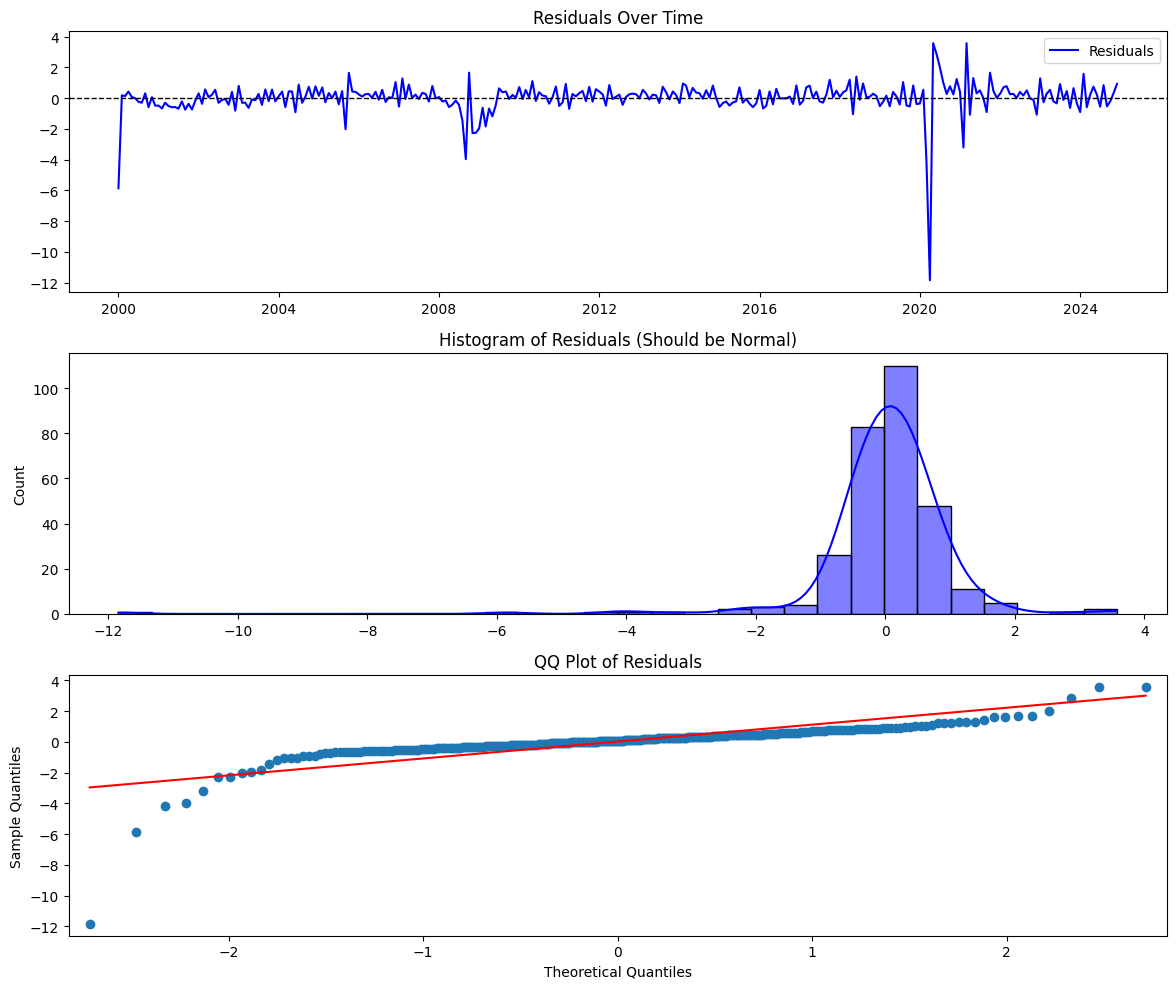

Ljung-Box Test p-value: 0.3152 (p > 0.05 means white noise)
Shapiro-Wilk Test p-value: 0.0000 (p > 0.05 means normality)
⚠️ No autocorrelation, but residuals may not be normal.


In [13]:
# Example: Analyze INDPRO from FRED
analyze_fred_series(
    api_key='fe3741e38a5245c3cc826f2d6ae3e1f2',
    series_id='INDPRO',
    start_date='2000-01-01',
    pct_change=False  # Set True for YoY Inflation
)